In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from PIL import Image
import pickle

In [2]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
def extract_features(directory):
	model=VGG16()
	model.layers.pop()
	model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
	print(model.summary())
	features = {}
	for name in listdir(directory):
		filename=directory + '/' + name
		#print(filename)
		image=load_img(filename, target_size=(224, 224))
		image=img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
		print('>%s' % name)
		#print(name)
	return features

directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

KeyboardInterrupt: 

In [3]:
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [4]:
import pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [5]:
with open('captions.txt', 'r', encoding='utf-8') as f:
    next(f)
    captions_doc = f.read()

In [6]:
captions_doc

'1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .\n1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .\n1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .\n1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .\n1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .\n1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .\n1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .\n1002674143_1b742ab4b8.j

In [7]:
from tqdm import tqdm
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 263326.19it/s]


In [8]:
len(mapping)

8091

In [9]:
#preprocess text data
def clean(mapping):
    for key, captions in mapping.items():
        for i in range (len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('^A-Za-z','')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] =caption

In [10]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
clean(mapping)

In [12]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [13]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
len(all_captions)


40455

In [15]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [18]:
#Train Test Split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [30]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y=list(), list(), list()
    n = 0
    while 1 :
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2),np.array(y)
                    yield [X1, X2], y
                    X1, X2, y = list(), list(), list()
                    n=0

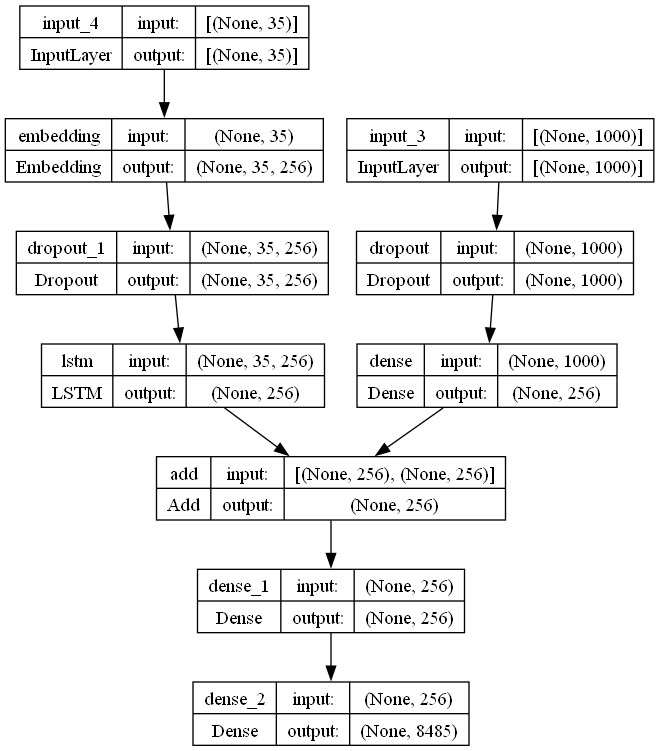

In [20]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model
from keras.utils import plot_model
inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)

fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, to_file='model.png', show_shapes=True)

In [23]:
epochs = 50
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)



202/202 [==============================] - 438s 2s/step - loss: 2.0411


In [25]:
model.save('best_model.h5')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [27]:
def idx_to_word(integer, tokenizer):
    for word , index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
def predict_caption(model,image,tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence],verbose=0)
        yhat = np.argmax(yhat)
        word= idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq':
            break
    return in_text

---------------------------Actual captions ----------------
startseq blonde horse and blonde girl in black sweatshirt are staring at fire in barrel endseq
startseq girl and her horse stand by fire endseq
startseq girl holding horse 's lead behind fire endseq
startseq "a man and girl and two horses are near contained fire ." endseq
startseq two people and two horses watching fire endseq
---------------------------Predicted Images-----------------
startseq man and woman are sitting on bench with fire cutouts endseq


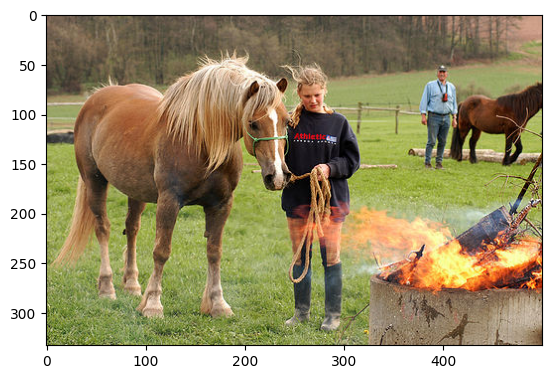

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join('Flicker8k_Dataset', image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]

    print('---------------------------Actual captions ----------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print('---------------------------Predicted Images-----------------')
    print(y_pred)

    plt.imshow(image)
    plt.show()  

generate_caption("10815824_2997e03d76.jpg")


---------------------------Actual captions ----------------
startseq man maneuvers motorcycle through rocky stream endseq
startseq motorcycle rider navigating his bike over stone obstacle endseq
startseq young man is in stream with his dirt bike endseq
startseq bmx biker in shallow stream with current performing wheelie endseq
startseq the man is dirt bike riding is the stream and climbing the rocks on the bank of the water endseq
---------------------------Predicted Images-----------------
startseq man in blue helmet riding bike on curved road endseq


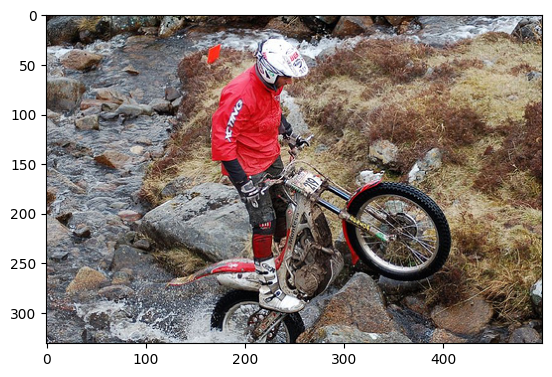

In [35]:
generate_caption("152029243_b3582c36fa.jpg")

---------------------------Actual captions ----------------
startseq kayaker kayaks through the water endseq
startseq person kayaking in the ocean endseq
startseq person kayaks in the middle of the ocean on grey day endseq
startseq person rows boat over large body of water endseq
startseq person in boat with paddle in hand endseq
---------------------------Predicted Images-----------------
startseq man is paddling kayak through the ocean endseq


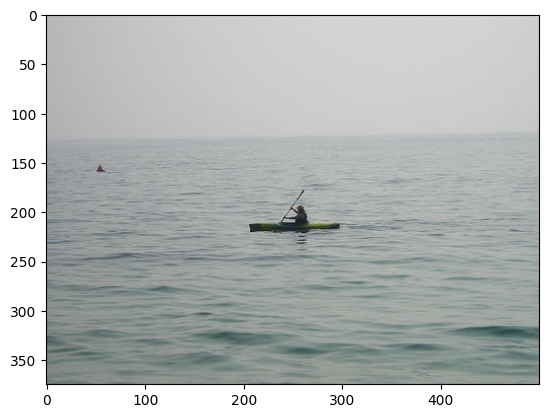

In [33]:
generate_caption("19212715_20476497a3.jpg")

In [32]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted =list(), list()

for key in tqdm(test):
    captions =mapping[key]
    y_pred=predict_caption(model, features[key], tokenizer,max_length)
    actual_captions=[caption.split() for caption  in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(1/3, 1/3, 1/3, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

100%|██████████████████████████████████████████████████████████████████████████████| 1619/1619 [19:35<00:00,  1.38it/s]


BLEU-1: 0.501474
BLEU-2: 0.273554
BLEU-3: 0.162681
BLEU-4: 0.095266


In [34]:
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(1/3, 1/3, 1/3, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.501474
BLEU-2: 0.273554
BLEU-3: 0.162681
BLEU-4: 0.095266
